# Reaction Rates

In this section, we will teach how to assign custom rates based on the meta-species states and how to write custom rate expressions other than mass action kinetics. 
Let us start with some meta-species definitions. 

In [25]:
from mobspy import *

Age, Mortal, Infectable, Virus = BaseSpecies()
Replicator = New(Age)

Age.young >> Age.old [1]

For any meta-reaction, if a number is used inside the brackets next to a meta-reaction, MobsPy will automatically construct the reaction rate using mass-action kinetics using the number as a reaction rate constant 
if the model is deterministic. If the model is stochastic, we use the propensity expression, which considers the factorial division, with the number in the brackets multiplying the propensity expression. 
The expression used for each reaction can be verified using the compile method for the simulation object.

MobsPy also allows the user to assign rates according to the meta-species states. To do so, the user can pass a function as a meta-reaction rate by either defining it inside the brackets with Python's innate lambda notation or writing its name when previously defined. 
If a function is used, MobsPy will pass the states of the meta-species of the reactants to the arguments of the function in matching order for all reactions defined by that meta-reaction.
The states can then be queried for characteristics and return different values based on the result of the query. 

For example, we define a duplication reaction that depends on age. In the reaction below, meta-species with the old state have a higher reaction rate constant:

In [26]:
Replicator >> 2*Replicator.young [lambda r1: 2 if r1.old else 1]

To continue we will define three tipes of Cells - `C1`, `C2`, and `C3` - and two types of viruses - `V1` and `V2`. 

In [27]:
Cell = Infectable * Age * Mortal
C1, C2, C3 = New(Cell)
V1, V2 = New(Virus)

We now define an infection reaction with rates that depend on the type of Cell and Virus used. 

In this case, the user has two options, and we will list both here. 
The first one uses the method `.is_a(meta species)` applied to the arguments of a function used as a rate. This method returns true if the reactant is or inherits from the given meta-species passed as an argument.

In [28]:

def infection_rate_1(r1, r2): 
    factor = 1
    if r1.is_a(C1):
        factor = 1.1*factor
    else:
        factor = 1.2*factor
    
    if r2.is_a(V1):
        factor = 0.8*factor
    elif r2.is_a(V2):
        factor = 1.1*factor
    else:
        factor = 1.2*factor
    
    print(f'The reactants {r1.get_state()} and {r2.get_state()} yield a rate constant of: {factor}')
    return factor
    

Infectable.not_infect + Virus >> Infectable.infected [infection_rate_1]

S_test = Simulation(C1 | C2 | C3 | V1 | V2)
S_test.compile(verbose=False)

The reactants C1.not_infect.young and V1 yield a rate constant of: 0.8800000000000001
The reactants C1.not_infect.old and V1 yield a rate constant of: 0.8800000000000001
The reactants C1.not_infect.young and V2 yield a rate constant of: 1.2100000000000002
The reactants C1.not_infect.old and V2 yield a rate constant of: 1.2100000000000002
The reactants C2.not_infect.young and V1 yield a rate constant of: 0.96
The reactants C2.not_infect.old and V1 yield a rate constant of: 0.96
The reactants C2.not_infect.young and V2 yield a rate constant of: 1.32
The reactants C2.not_infect.old and V2 yield a rate constant of: 1.32
The reactants C3.not_infect.young and V1 yield a rate constant of: 0.96
The reactants C3.not_infect.old and V1 yield a rate constant of: 0.96
The reactants C3.not_infect.young and V2 yield a rate constant of: 1.32
The reactants C3.not_infect.old and V2 yield a rate constant of: 1.32


Compiling model


The other way is to use the `get_state` method to return the state of the meta-species currently used to construct the reaction.
With this string, one can find the meta-species name and use a Python dictionary to define the rates. 

In [29]:

infection_dict = {'C1':{'V1':1.1 , 'V2':1.3 , 'V3':1.7}, 
                  'C2':{'V1':1.4 , 'V2':1.1 , 'V3':1.9},
                  'C3':{'V1':1.9 , 'V2':1.2 , 'V3':1.6}} 


def infection_rate_2(r1, r2): 
    r1_name, r2_name = r1.get_state().split('.')[-1], r2.get_state().split('.')[-1]
    factor = infection_dict[r1_name][r2_name]
    print(f'The reactants {r1.get_state()} and {r2.get_state()} yield a rate constant of: {factor}')
    return factor


S_test_2 = Simulation(C1 | C2 | C3 | V1 | V2)
S_test_2.compile(verbose=False)

Compiling model


The reactants C1.not_infect.young and V1 yield a rate constant of: 0.8800000000000001
The reactants C1.not_infect.old and V1 yield a rate constant of: 0.8800000000000001
The reactants C1.not_infect.young and V2 yield a rate constant of: 1.2100000000000002
The reactants C1.not_infect.old and V2 yield a rate constant of: 1.2100000000000002
The reactants C2.not_infect.young and V1 yield a rate constant of: 0.96
The reactants C2.not_infect.old and V1 yield a rate constant of: 0.96
The reactants C2.not_infect.young and V2 yield a rate constant of: 1.32
The reactants C2.not_infect.old and V2 yield a rate constant of: 1.32
The reactants C3.not_infect.young and V1 yield a rate constant of: 0.96
The reactants C3.not_infect.old and V1 yield a rate constant of: 0.96
The reactants C3.not_infect.young and V2 yield a rate constant of: 1.32
The reactants C3.not_infect.old and V2 yield a rate constant of: 1.32


## MobsPy Expressions

If one wishes to assign rates other than mass action kinetics, one can use MobsPy Expressions. 
The arguments passed to a rate function can be used to construct rate expressions by operating on them and storing the operations performed upon them to return a new expression to the compiler. 
For instance, the code below shows how to write a Hill function:

Compiling model
Starting Simulator
Simulation is Over


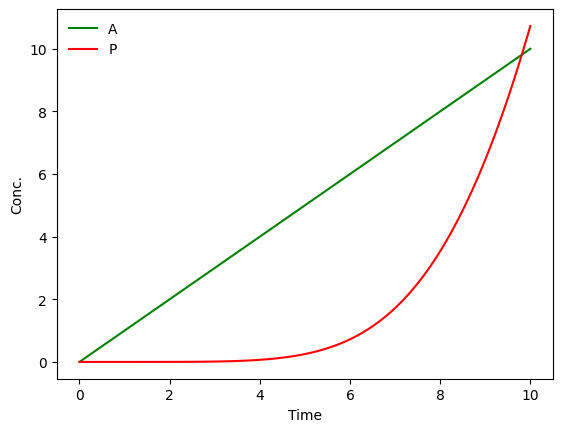

In [30]:
A, P = BaseSpecies()

Zero >> A [1]
A >> A + P [lambda r1: r1/(1 + (10/r1)**4)]

S = Simulation(A | P)
S.duration = 10
S.run()

Here is another expression example with a meta-species with characteristics: 

In [31]:
B, P = BaseSpecies()
B.b1, B.b2, B.b3

B + P >> B + 2*P [lambda r1, r2: r1*(100-r2)]

S = Simulation(B | P)
print(S.compile())

Compiling model



Species
B.b1,0
B.b2,0
B.b3,0
P,0

Mappings
B :
B.b1
B.b2
B.b3
P :
P

Parameters
volume,1

Reactions
reaction_0,{'re': [(1, 'B.b1'), (1, 'P')], 'pr': [(1, 'B.b1'), (2, 'P')], 'kin': '(B.b1*(100-P))'}
reaction_1,{'re': [(1, 'B.b2'), (1, 'P')], 'pr': [(1, 'B.b2'), (2, 'P')], 'kin': '(B.b2*(100-P))'}
reaction_2,{'re': [(1, 'B.b3'), (1, 'P')], 'pr': [(1, 'B.b3'), (2, 'P')], 'kin': '(B.b3*(100-P))'}



Units are fully compatible with expressions. 
MobsPy executes all unit operations written inside the expression and checks if the resulting unit is indeed a reaction rate for the user, yielding a compilation error if they are not. 

Furthermore, reactants have units. 
Reactants can either be concentrations, with units of $\frac{1}{[Volume]}$, or they can represent counts (total amount) and have no units. 
The user can specify if the reactants are written in terms of concentration or counts using the resulting unit of the expression. 

When the resulting unit of the expression is $$\frac{1}{[Time] \cdot [Volume]}$$ then the reactants are considered to be a concentration. 
Otherwise, if it is $$\frac{1}{[Time]}$$ then the reactants are considered to represent the total amount. Below, we show an example:

In [32]:
A_Count, A_Con, P = BaseSpecies()

A_Count >> A_Count + P [lambda r: (100-r)/u.s]
A_Con >> A_Con + P [lambda r: (100/u.l-r)/u.s]

S = Simulation(A_Count | A_Con | P)
print(S.compile())

Compiling model



Species
A_Con,0
A_Count,0
P,0

Mappings
A_Con :
A_Con
A_Count :
A_Count
P :
P

Parameters
volume,1

Reactions
reaction_0,{'re': [(1, 'A_Con')], 'pr': [(1, 'A_Con'), (1, 'P')], 'kin': '(((100.00000000000003-(A_Con/volume))/1))*volume'}
reaction_1,{'re': [(1, 'A_Count')], 'pr': [(1, 'A_Count'), (1, 'P')], 'kin': '((100-A_Count)/1)'}

